In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [3]:
input_location = 'KTH-io-aware-filter'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'no-future-1', 'fcfs']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware-filter/backfill-0_schedule.csv', '../output/KTH-io-aware-filter/backfill-1_schedule.csv', '../output/KTH-io-aware-filter/backfill-2_schedule.csv', '../output/KTH-io-aware-filter/backfill-3_schedule.csv', '../output/KTH-io-aware-filter/backfill-4_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-2_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-3_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-4_schedule.csv', '../output/KTH-io-aware-filter/fcfs_schedule.csv', '../output/KTH-io-aware-filter/filler-sjf_schedule.csv', '../output/KTH-io-aware-filter/filler_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-05-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-0_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-15-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-20-1_schedule.

In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 fcfs
 filler
 no-future-1


In [6]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-future-1


In [7]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [8]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [9]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [10]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [11]:
def storage_queue(js, GB=False):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    if GB:
        df['total_storage'] = (df['total_storage'] / (1000 * 1000 * 1000)).round()
    return evalys.metrics.compute_load(df, 'submission_time', 'starting_time', 'total_storage')

In [12]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [13]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [14]:
metrics.T

,filler,backfill-1,no-future-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88587e+07,2.87862e+07,4.22482e+07,3.79972e+07
max_slowdown,1.00023,1.00024,1.00024,1.00024
max_turnaround_time,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975919,0.975911,0.975914,0.975916
mean_turnaround_time,223.371,223.917,223.248,224.797
mean_waiting_time,0,0,0,0
nb_computing_machines,109,109,109,109


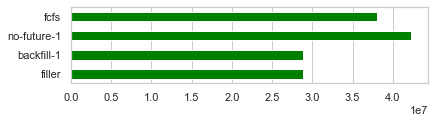

In [44]:
# ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax = metrics['makespan'].plot.barh(color='green', figsize=(6.4,1.4))
ax.grid(axis='y')
plt.savefig('../../images/results/reservation_io-aware_makespan.pdf', bbox_inches='tight')

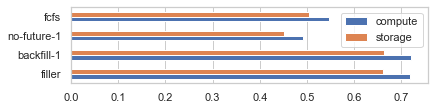

In [45]:
# ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(6.4,1.4))
ax.legend(['compute', 'storage'])
ax.grid(axis='y')
plt.savefig('../../images/results/reservation_io-aware_utilisation.pdf', bbox_inches='tight')

In [46]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown,bounded_slowdown
0,filler,0.000000e+00,1.993761e+02,1.000000,1.000000
1,filler,0.000000e+00,4.308942e+00,1.000000,1.000000
2,filler,2.040415e+04,2.084481e+04,47.303797,34.741347
3,filler,1.988681e+04,2.701097e+04,3.791459,3.791459
4,filler,1.845115e+04,2.531219e+04,3.689263,3.689263
...,...,...,...,...,...
28448,fcfs,4.519629e+06,4.540588e+06,216.640355,216.640355
28449,fcfs,4.490202e+06,4.504479e+06,315.496471,315.496471
28450,fcfs,4.490019e+06,4.504311e+06,315.146287,315.146287
28451,fcfs,4.486077e+06,4.499185e+06,343.231265,343.231265


In [48]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,no-future-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.084075e+04,14561.065035,1.552292e+06,5.634667e+06
std,1.435025e+05,40986.225159,4.869283e+06,2.656175e+06
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,1.147151e+04,3.373835e+06
50%,0.000000e+00,4.241377,5.191546e+04,6.134252e+06
75%,4.815074e+03,9314.759640,4.165092e+05,7.867331e+06
max,5.938432e+06,660955.100730,2.950410e+07,9.286774e+06


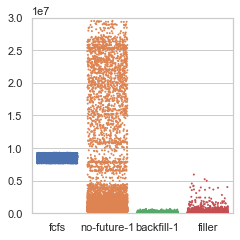

In [49]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=8000, columns='waiting_time') for schedule in schedule_names])
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
# sns.stripplot(data=waiting_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=3*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
# fig.savefig('../../images/results/reservation_io-aware_waiting-time_dist.png', bbox_inches='tight', dpi=600)
fig.savefig('../../images/results/reservation_io-aware_waiting-time_dist.pdf', bbox_inches='tight')

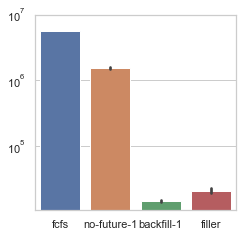

In [50]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=waiting_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_io-aware_waiting-time_mean.pdf', bbox_inches='tight')

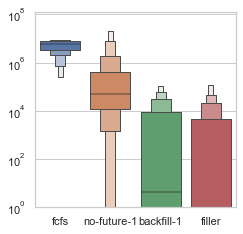

In [51]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(1)
fig.savefig('../../images/results/reservation_io-aware_waiting-time_boxen.pdf', bbox_inches='tight')

In [52]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,no-future-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.962341e+04,23345.399482,1.561072e+06,5.643462e+06
std,1.450631e+05,48033.555144,4.869995e+06,2.657402e+06
min,9.040000e-02,0.090400,3.396170e-01,6.942760e-01
25%,1.677004e+02,177.306547,1.783793e+04,3.378093e+06
50%,5.219755e+03,5973.278602,6.237754e+04,6.135455e+06
75%,1.992174e+04,23951.637759,4.301406e+05,7.868823e+06
max,5.938612e+06,676106.711923,2.951316e+07,9.338928e+06


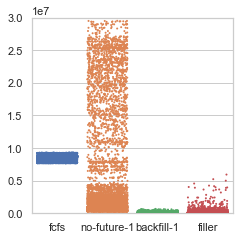

In [53]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=8000, columns='turnaround_time') for schedule in schedule_names])
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=3*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_io-aware_turnaround-time_dist.pdf', bbox_inches='tight')

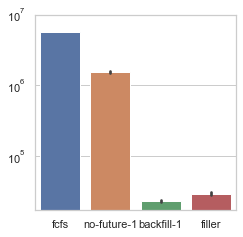

In [54]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=turnaround_times, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**7)
fig.savefig('../../images/results/reservation_io-aware_turnaround-time_mean.pdf', bbox_inches='tight')

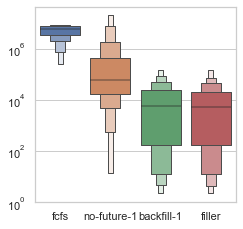

In [55]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(1)
fig.savefig('../../images/results/reservation_io-aware_turnaround-time_boxen.pdf', bbox_inches='tight')

In [56]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,no-future-1,fcfs
count,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,197.498080,181.475132,1.455230e+04,1.471604e+05
std,1562.150931,1123.992847,7.122272e+04,6.364391e+05
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,1.000000,1.000000,4.904214e+00,5.901666e+02
50%,1.000000,1.002834,1.206066e+02,6.254731e+03
75%,4.992995,6.790060,2.747682e+03,9.862773e+04
max,126152.232149,72686.529312,3.046557e+06,6.894638e+07


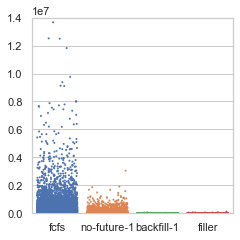

In [66]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=8000, columns='slowdown') for schedule in schedule_names])
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=1.4*10**7)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_io-aware_slowdown_dist.pdf', bbox_inches='tight')

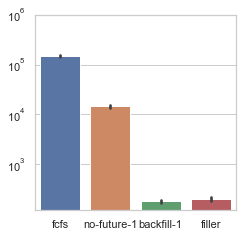

In [58]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=slowdown, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**6)
fig.savefig('../../images/results/reservation_io-aware_slowdown_mean.pdf', bbox_inches='tight')

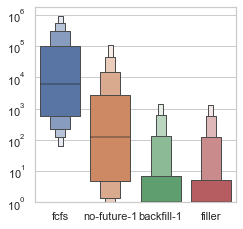

In [59]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(1)
fig.savefig('../../images/results/reservation_io-aware_slowdown_boxen.pdf', bbox_inches='tight')

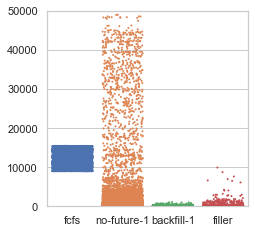

In [67]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']].nlargest(n=8000, columns='bounded_slowdown') for schedule in schedule_names])
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'], size=2, jitter=0.4)
ax.set_ylim(0)
ax.set_ylim(top=50000)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_io-aware_bounded-slowdown_dist.pdf', bbox_inches='tight')

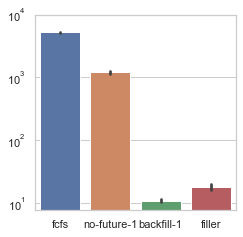

In [68]:
# Mean, logscale
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(top=10**4)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_io-aware_bounded-slowdown_mean.pdf', bbox_inches='tight')

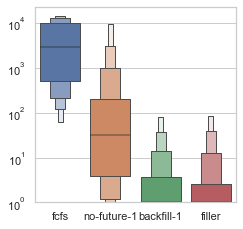

In [69]:
# Boxenplot
# fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(3.6,3.6))
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax, order=['fcfs', 'no-future-1', 'backfill-1', 'filler'])
ax.set_yscale('log')
ax.set_ylim(1)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/reservation_io-aware_bounded-slowdown_boxen.pdf', bbox_inches='tight')

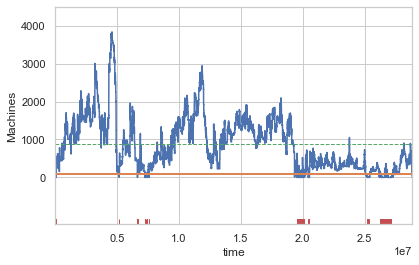

In [15]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)
# ax.set_xlim((0, max_makespan))
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_io-aware_compute-load_filler.pdf', bbox_inches='tight')

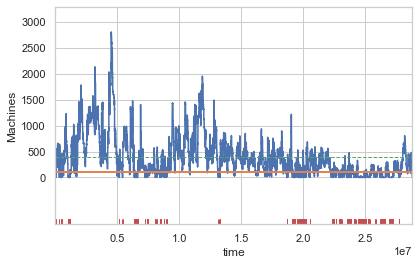

In [16]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_io-aware_compute-load_backfill.pdf', bbox_inches='tight')

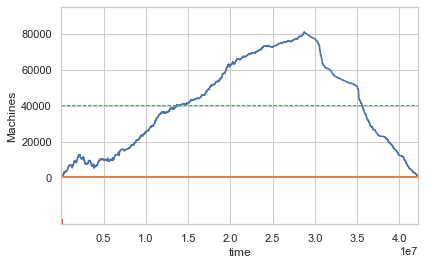

In [17]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['no-future-1'].queue, nb_resources=96, ax=ax)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_io-aware_compute-load_future.pdf', bbox_inches='tight')

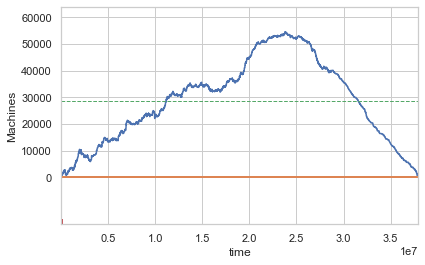

In [18]:
# fig, ax = plt.subplots(figsize=(20,8))
fig, ax = plt.subplots(figsize=(6.4,4))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
fig.savefig('../../images/results/reservation_io-aware_compute-load_fcfs.pdf', bbox_inches='tight')

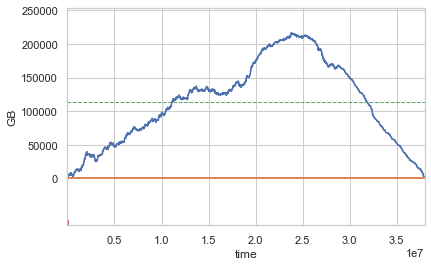

In [19]:
fig, ax = plt.subplots(figsize=(6.4,4))
# evalys.visu.legacy.plot_load(storage_queue(jobsets['fcfs']), 480000000000)
evalys.visu.legacy.plot_load(storage_queue(jobsets['fcfs'], GB=True), 480)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
# ax.set_ylabel('Bytes')
ax.set_ylabel('GB')
fig.savefig('../../images/results/reservation_io-aware_storage-load_fcfs.pdf', bbox_inches='tight')

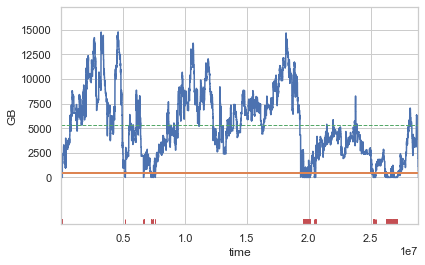

In [20]:
fig, ax = plt.subplots(figsize=(6.4,4))
# evalys.visu.legacy.plot_load(storage_queue(jobsets['filler']), 480000000000)
evalys.visu.legacy.plot_load(storage_queue(jobsets['filler'], GB=True), 480)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
# ax.set_ylabel('Bytes')
ax.set_ylabel('GB')
fig.savefig('../../images/results/reservation_io-aware_storage-load_filler.pdf', bbox_inches='tight')

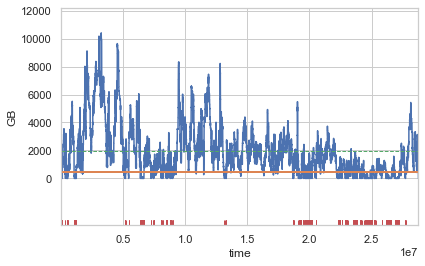

In [21]:
fig, ax = plt.subplots(figsize=(6.4,4))
# evalys.visu.legacy.plot_load(storage_queue(jobsets['backfill-1']), 480000000000)
evalys.visu.legacy.plot_load(storage_queue(jobsets['backfill-1'], GB=True), 480)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
# ax.set_ylabel('Bytes')
ax.set_ylabel('GB')
fig.savefig('../../images/results/reservation_io-aware_storage-load_backfill.pdf', bbox_inches='tight')

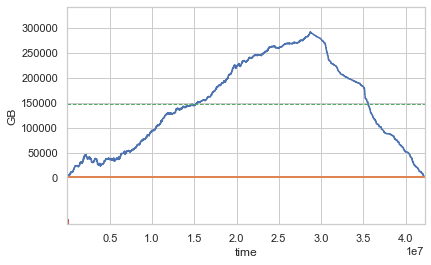

In [22]:
fig, ax = plt.subplots(figsize=(6.4,4))
# evalys.visu.legacy.plot_load(storage_queue(jobsets['no-future-1']), 480000000000)
evalys.visu.legacy.plot_load(storage_queue(jobsets['no-future-1'], GB=True), 480)
ticks = [tick for tick in ax.get_yticks() if tick >=0]
ax.set_yticks(ticks[:-1])
ax.get_legend().remove()
# ax.set_ylabel('Bytes')
ax.set_ylabel('GB')
fig.savefig('../../images/results/reservation_io-aware_storage-load_future.pdf', bbox_inches='tight')